In [1]:
import os, sys, re, pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import tensorflow as tf
from tensorflow import keras
print(sys.version_info)

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)


In [2]:
for module in tf, mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

tensorflow 2.0.0
matplotlib 3.1.1
numpy 1.16.4
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [3]:
ORIGIN_DATA_DIR = os.getcwd() + '/all_fearures/BX-CSV-Dump/'
FILTERED_DATA_DIR = os.getcwd() + '/tmp/'

In [4]:
ORIGIN_DATA_DIR = os.getcwd()+'/all_fearures/BX-CSV-Dump/'
FILTERED_DATA_DIR = os.getcwd()+'/tmp/'
class DataLoad:
    def __init__(self):
        '''
        books_with_blurbs.csv cloumns: ISBN,text,Author,Year,Publisher,Blurb
        BX-Book-Ratings.csv cloumns: User-ID,ISBN,Book-Rating
        BX-Books.csv cloumns: ISBN,Book-text,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
        BX-Users.csv cloumns: User-ID,Location,Age
        '''
        self.BX_Users = self.load_origin('BX-Users')
        self.BX_Book_Ratings = self.load_origin('BX-Book-Ratings')
        self.books_with_blurbs = self.load_origin('books_with_blurbs', ',')
        #合并三个表
        self.features = self.get_features()
        self.labels = self.features.pop('Book-Rating')

    def load_origin(self, 
        filename: "根据文件名获取源文件，获取正确得columns、values等值", 
        sep: "因为源文件的分隔方式sep不同，所以通过传参改编分隔方式"="\";\"", 
        )->pd.DataFrame:
        '''
        获取原始数据，第一遍获取后将用pickle保存到本地，方便日后调用
        '''
        try:
            # 从缓存的文件夹FILTERED_DATA_DIR获取基本被过滤后的文件
            pickled_data = pickle.load(open(FILTERED_DATA_DIR+filename+'.p', mode='rb'))
            return pickled_data
        except FileNotFoundError:
            # 如果缓存的文件不存在或者没有，则在源目录ORIGIN_DATA_DIR获取
            all_fearures = pd.read_csv(ORIGIN_DATA_DIR+filename+'.csv', engine='python',sep=sep, encoding='utf-8')
            # \";\"  初始过滤的文件
            # ,      初始不需要过滤的文件
            data_dict = {"\";\"":self.filtrator(all_fearures), ',':all_fearures}
            # 因为没获得处理后的文件，所以我们在获取源文件后可以保存一下处理后的文件
            pickle.dump((data_dict[sep]), open(FILTERED_DATA_DIR+filename+'.p', 'wb'))
            return data_dict[sep]
        except UnicodeDecodeError as e:
            ''' 测试时经常会出现编码错误，如果尝试更换编码方式无效，可以将编码错误的部分位置重新复制粘贴就可以了，这里我们都默认UTF-8'''
            print('UnicodeDecodeError:',e)
        except pd.errors.ParserError as e:
            print("connect error|pandas Error: %s" % e)

    def filtrator(self, 
        f_data: "输入需要进行初步filter的数据"
        )->pd.DataFrame:
        '''
        源文件中的columns和各个值得第一列的第一个字符和最后一列的最后一个字符都带有双引号‘"’,需要将其filter,Location字段当用户Age为null的时候，末尾会有\";NULL字符串 ，直接用切片调整
        '''
        Nonetype_age = 0
        f_data = f_data.rename(columns={f_data.columns[0]:f_data.columns[0][1:], f_data.columns[-1]:f_data.columns[-1][:-1]})
        f_data[f_data.columns[0]] = f_data[f_data.columns[0]].map(lambda v:v[1:] if v!=None else Nonetype_age)
        f_data[f_data.columns[-1]] = f_data[f_data.columns[-1]].map(lambda v:v[:-1] if v!=None else Nonetype_age)
        try:
            f_data = f_data[f_data['Location'].notnull()][f_data[f_data['Location'].notnull()]['Location'].str.contains('\";NULL')]
            f_data['Location'] = f_data['Location'].map(lambda location:location[:-6])
        except:
            pass
        return f_data

    def get_features(self):
        '''
        获取整个数据集的所有features，并对每个文本字段作xxxxx
        User-ID
        Location
        ISBN
        Book-Rating
        Title
        Author
        Year
        Publisher
        Blurb
        '''
        try:
            # 从缓存的文件夹FILTERED_DATA_DIR获取features的文件
            pickled_data = pickle.load(open(FILTERED_DATA_DIR+'features.p', mode='rb'))
            return pickled_data
        except FileNotFoundError:
            # 将所有的数据组成features大表
            all_fearures = pd.merge(pd.merge(self.BX_Users, self.BX_Book_Ratings), self.books_with_blurbs)
            # 因为没获得处理后的文件，所以我们在获取源文件后可以保存一下处理后的文件
            all_fearures.pop('Age')
            all_fearures['Title'] = self.feature2int(all_fearures['Title'], 'text', 15)
            all_fearures['Blurb'] = self.feature2int(all_fearures['Blurb'], 'text', 200)
            all_fearures['ISBN'] = self.feature2int(all_fearures['ISBN'], 'word')
            all_fearures['Author'] = self.feature2int(all_fearures['Author'], 'word')
            all_fearures['Publisher'] = self.feature2int(all_fearures['Publisher'], 'word')
            all_fearures['User-ID'] = self.feature2int(all_fearures['User-ID'], 'word')
            all_fearures['Year'] = self.feature2int(all_fearures['Year'], 'word')
            all_fearures['Location'] = self.feature2int(all_fearures['Location'], 'list')
            all_fearures['Book-Rating'] = all_fearures['Book-Rating'].astype('float32')
#             pickle.dump(all_fearures, open(FILTERED_DATA_DIR+'features.p', 'wb'))
            return all_fearures

    def feature2int(self, 
        feature:'特征值',
        feature_type:'text/word/list',
        length:'文本设置的最大长度' = 0,
        ):
        '''
        将文本字段比如title、blurb只取英文单词，并用空格为分隔符，做成一个带index值的集合，并用index值表示各个单词，作为文本得表示
        '''
        pattern = re.compile(r'[^a-zA-Z]')
        filtered_map = {val:re.sub(pattern, ' ', str(val)) for ii,val in enumerate(set(feature)) }
        letter_filter = lambda feature:feature.map({val:re.sub(pattern, ' ', str(val)) for ii,val in enumerate(set(feature)) })
        text_words = set()
        filtered_feature = letter_filter(feature)
        for val in filtered_feature.str.split():
            text_words.update(val)
        text_words.add('<PAD>')
        text2int = {val:ii for ii, val in enumerate(text_words)}
        text_map = {val:[text2int[row] for row in filtered_map[val].split()][:length] for ii,val in enumerate(set(feature))}
        for key in text_map:
            for cnt in range(length - len(text_map[key])):
                text_map[key].insert(len(text_map[key]) + cnt,text2int['<PAD>'])
        word_map = {val:ii for ii,val in enumerate(set(feature))}

        try:
            cities = set()
            for val in feature.str.split(','):
                cities.update(val)
            city_index = {val:ii for ii, val in enumerate(cities)}
            list_map = {val:[city_index[row] for row in val.split(',')][:3] for ii,val in enumerate(set(feature))}
        except AttributeError :
            list_map = {}
        

        feature_dict = {
            'text':feature.map(text_map),
            'word':feature.map(word_map),
            'list':feature.map(list_map),
            }
        return feature_dict[feature_type]

    def __del__(self):
        pass


In [5]:
origin_DATA = DataLoad()

In [6]:
print(origin_DATA.features)

        User-ID            Location   ISBN  \
0         17548    [2923, 416, 656]  11519   
1         17548    [2923, 416, 656]  25101   
2         21058   [1247, 6146, 656]  25101   
3         10993   [1654, 6970, 359]  25101   
4         14844   [4151, 5935, 359]  25101   
...         ...                 ...    ...   
172097     3845   [1742, 4236, 359]  10516   
172098     8077   [6026, 4126, 359]  32828   
172099     8077   [6026, 4126, 359]  10420   
172100     8077   [6026, 4126, 359]  20810   
172101     5275  [2217, 2997, 4450]  26390   

                                                    Title  Author  Year  \
0       [3326, 3659, 14971, 16014, 16014, 16014, 16014...   14554    64   
1       [9506, 19945, 9490, 8400, 16418, 11309, 9149, ...   12943    72   
2       [9506, 19945, 9490, 8400, 16418, 11309, 9149, ...   12943    72   
3       [9506, 19945, 9490, 8400, 16418, 11309, 9149, ...   12943    72   
4       [9506, 19945, 9490, 8400, 16418, 11309, 9149, ...   12943    72 

In [7]:
origin_DATA.features.shape


(172102, 8)

In [8]:
# user-id的字典,总共有28836个用户
all_user = len(set(origin_DATA.features['User-ID']))
new_user_id = {val: i for i, val in enumerate(set(origin_DATA.features['User-ID']))}
print('all user id = ', all_user)
# location的数量=7573(从0开始的)
all_location = max([j for i in origin_DATA.features.Location for j in i]) +1 
print('all location = ', all_location)

all user id =  28836
all location =  7573


In [9]:
# ISBN总数
all_isbn = len(set(origin_DATA.features['ISBN']))
print('all isbn = ', all_isbn)
# author总数
all_author = len(set(origin_DATA.features['Author']))
print('all author = ', all_author)
# year总数
all_year = len(set(origin_DATA.features['Year']))
print('all year = ', all_year)
# publish总数
all_publisher = len(set(origin_DATA.features['Publisher']))
print('all publisher = ', all_publisher)
# title中所有单词总数
all_title_words = max([j for i in origin_DATA.features.Title for j in i]) +1 
print('all title words = ', all_title_words)
# blurb中所有单词总数
all_blurb_words = max([j for i in origin_DATA.features.Blurb for j in i]) +1 
print('all blurb words = ', all_blurb_words)

all isbn =  38036
all author =  15196
all year =  81
all publisher =  2909
all title words =  23816
all blurb words =  127186


In [10]:
def get_inputs():
    # 用户特征输入
    user_id = keras.layers.Input(shape=(1,), dtype='int32', name='user_id_input')
    user_location = keras.layers.Input(shape=(3,), dtype='int32', name='user_location_input')
    
    # 书籍特征输入
    book_isbn = keras.layers.Input(shape=(1,),  dtype='int32', name='book_isbn_input')
    book_author = keras.layers.Input(shape=(1,),  dtype='int32', name='book_author_input')
    book_year = keras.layers.Input(shape=(1,),  dtype='int32', name='book_year_input')
    book_publisher = keras.layers.Input(shape=(1,),  dtype='int32', name='book_publisher_input')  
    book_title = keras.layers.Input(shape=(15, ), dtype='int32', name='book_title_input')
    book_blurb = keras.layers.Input(shape=(200, ), dtype='int32', name='book_blurb_input')
    return user_id, user_location, book_isbn, book_author, book_year, book_publisher, book_title, book_blurb

In [11]:
# 嵌入矩阵的维度
embed_dim = 16
embed_dim_words = 32

In [12]:
def user_embed_layer(u_id, u_loca):
    user_id_embedd = keras.layers.Embedding(all_user, embed_dim, name='user_id_embedding')(u_id)
    user_loca_embedd = keras.layers.Embedding(all_location, embed_dim , name='user_loca_embedding')(u_loca)
    return user_id_embedd, user_loca_embedd

In [13]:
def book_emded_layer(b_isbn, b_atuhor, b_year, b_publisher, b_title, b_blurb):
    book_isbn_embedd = keras.layers.Embedding(all_isbn, embed_dim, name='book_isbn_embedding')(b_isbn)
    book_author_embedd = keras.layers.Embedding(all_author, embed_dim, name='book_author_embedding')(b_atuhor)
    book_year_embedd = keras.layers.Embedding(all_year, embed_dim, name='book_year_embedding')(b_year)
    book_publisher_embedd = keras.layers.Embedding(all_publisher, embed_dim, name='book_publisher_embedding')(b_publisher)
    
    book_title_embedd = keras.layers.Embedding(all_title_words, embed_dim_words, name='book_title_embedding')(b_title)
    book_blurb_embedd = keras.layers.Embedding(all_blurb_words, embed_dim_words, name='book_blurb_embedding')(b_blurb)
    return book_isbn_embedd, book_author_embedd, book_year_embedd, book_publisher_embedd, book_title_embedd, book_blurb_embedd

In [14]:
def get_user_feature(u_id_embedd, u_loca_embedd):
    u_id_layer = keras.layers.Dense(64, activation='relu', name='u_id_dense')(u_id_embedd)
    # u_id_layer.shape = (?, 1, 64)
    # u_loca_layer.shape = (?, 64)
    # 这里可以再加个Dense
    u_loca_layer = keras.layers.LSTM(32, go_backwards=False, name='u_loca_lstm')(u_loca_embedd)
    u_loca_layer_lstm = keras.layers.Dense(64, activation='relu', name='u_loca_layer_lstm')(u_loca_layer)
    u_id_reshape = keras.layers.Reshape([64])(u_id_layer)
    u_combine = keras.layers.concatenate([u_id_reshape, u_loca_layer_lstm],axis=1, name='u_combine')
    print(u_combine.shape)
    # 这里能不能用激活函数
    u_feature_layer = keras.layers.Dense(200, name='u_feature_layer')(u_combine)
    print(u_feature_layer.shape)
    return u_feature_layer

In [15]:
b_dense = 16
def get_book_feature(b_isbn_embedd, b_author_embedd, b_year_embedd, b_publisher_embedd, b_title_embedd, b_blurb_embedd):
    # 首先对前4个特征连接Dense层
    b_isbn_dense = keras.layers.Dense(b_dense, activation='relu', name='b_isbn_dense')(b_isbn_embedd)
    b_author_dense = keras.layers.Dense(b_dense, activation='relu', name='b_author_dense')(b_author_embedd)
    b_year_dense = keras.layers.Dense(b_dense, activation='relu', name='b_year_dense')(b_year_embedd)
    b_publisher_dense = keras.layers.Dense(b_dense, activation='relu', name='b_publisher_dense')(b_publisher_embedd)
    # 合并这四个特征,  b_combine_four shape = (?, 1, 64)
    b_combine_four = keras.layers.concatenate([b_isbn_dense, b_author_dense, b_year_dense, b_publisher_dense], name='b_four_combine')
    print('b_combine_four.shape', b_combine_four.shape)
    # 对title进行卷积
    b_title_reshape = keras.layers.Lambda(lambda layer: tf.expand_dims(layer, 3))(b_title_embedd)  # shape=(?,15, 32, 1)
    print('b_title_reshape.shape = ', b_title_reshape.shape)
    b_title_conv = keras.layers.Conv2D(filters=8, kernel_size=(2, embed_dim_words), strides=1)(b_title_reshape)# shape=(?, 14, 1, 8)
    b_title_pool = keras.layers.MaxPool2D(pool_size=(14, 1), strides=1)(b_title_conv) # shape=(?,1, 1, 8)
    print('b_title_conv.shape = ', b_title_conv)
    print('b_title_pool.shape = ', b_title_pool)
    
    # 对blurb进行处理
    b_blurb_lstm = keras.layers.LSTM(32, name='b_blurb_lstm')(b_blurb_embedd) # shape = (?, 32)
    print('b_blurb_lstm.shape = ', b_blurb_lstm.shape)
    # 将title和blurb合并
    b_title_reshape = keras.layers.Reshape([b_title_pool.shape[3]])(b_title_pool)
    # b_combine_blurb_title.shape = (?, 40)
    b_combine_blurb_title = keras.layers.concatenate([b_title_reshape, b_blurb_lstm], axis=1, name='b_combine_blurb_title')
    print('b_combine_blurb_title.shape', b_combine_blurb_title.shape)
    b_blurb_title_dense = keras.layers.Dense(64, activation='relu', name='b_blurb_title_dense')(b_combine_blurb_title)
    # b_combine_four_reshape shape = (?, 64)
    b_combine_four_reshape = keras.layers.Reshape([b_combine_four.shape[2]], name='b_combine_four_reshape')(b_combine_four)
    # 合并所有的书籍特征
    b_combine_book = keras.layers.concatenate([b_combine_blurb_title, b_combine_four_reshape], axis=1, name='b_combine_book')
    # 得到书籍矩阵
    b_feature_layer = keras.layers.Dense(200, name='b_feature_layer')(b_combine_book)
    return b_feature_layer

In [16]:
def get_rating(user_feature, book_feature):
    multiply_layer = keras.layers.Lambda(lambda layer: tf.reduce_sum(layer[0]*layer[1], axis=1, keepdims=True), name = 'user_book_feature')((user_feature, book_feature))
    print(multiply_layer.shape)
    return multiply_layer

In [17]:
m = len(origin_DATA.features['Location'])
# 对location取3位数
loca = np.zeros((m, 3))
title = np.zeros((m, 15))
blurb = np.zeros((m, 200))
for i in range(m):
    loca[i] = np.array(origin_DATA.features['Location'][i])
    title[i] = np.array(origin_DATA.features['Title'][i])
    blurb[i] = np.array(origin_DATA.features['Blurb'][i])
print(loca[:-2])
print(title[:-2])
print(blurb[:-2])
input_features = [origin_DATA.features['User-ID'].to_numpy(), loca, 
                  origin_DATA.features['ISBN'].to_numpy(), origin_DATA.features['Author'].to_numpy(),
                 origin_DATA.features['Year'].to_numpy(), origin_DATA.features['Publisher'].to_numpy(), 
                 title, blurb]
labels = origin_DATA.labels.to_numpy()

[[2923.  416.  656.]
 [2923.  416.  656.]
 [1247. 6146.  656.]
 ...
 [1742. 4236.  359.]
 [6026. 4126.  359.]
 [6026. 4126.  359.]]
[[ 3326.  3659. 14971. ... 16014. 16014. 16014.]
 [ 9506. 19945.  9490. ...  7526. 16418. 13728.]
 [ 9506. 19945.  9490. ...  7526. 16418. 13728.]
 ...
 [21874. 22253. 17409. ... 16014. 16014. 16014.]
 [10877.  1586. 20115. ... 16014. 16014. 16014.]
 [18296. 12535. 16014. ... 16014. 16014. 16014.]]
[[100778.  83794. 107364. ...  42406.  42406.  42406.]
 [116767.   6708.  85552. ...  42406.  42406.  42406.]
 [116767.   6708.  85552. ...  42406.  42406.  42406.]
 ...
 [ 70697. 106375.  99183. ...  42406.  42406.  42406.]
 [ 47902.  38856.  93888. ...  42406.  42406.  42406.]
 [ 97224. 114172. 118605. ...  42406.  42406.  42406.]]


In [18]:
print(input_features[1].shape)

(172102, 3)


In [21]:
MODEL_DIR = './model/'

class model_network():
    def __init__(self):
        self.batchsize = 256
        self.epoch = 5
        self.best_loss = 999
    def creat_model(self):
        user_id, user_location, book_isbn, book_author, book_year, book_publisher, book_title, book_blurb = get_inputs()
        user_id_embedd, user_loca_embedd = user_embed_layer(user_id, user_location)
        book_isbn_embedd, book_author_embedd, book_year_embedd, book_publisher_embedd, book_title_embedd, book_blurb_embedd = book_emded_layer(book_isbn, book_author, book_year, book_publisher, book_title, book_blurb)
        u_feature_layer = get_user_feature(user_id_embedd, user_loca_embedd)
        b_feature_layer = get_book_feature(book_isbn_embedd, book_author_embedd, book_year_embedd, book_publisher_embedd, book_title_embedd, book_blurb_embedd)
        multiply_layer = get_rating(u_feature_layer, b_feature_layer)
        model = keras.Model(inputs=[user_id, user_location, book_isbn, book_author, book_year, book_publisher, book_title, book_blurb],
                    outputs=[multiply_layer])
        return model
    def train_model(self):
        model = self.creat_model()
        model.compile(optimizer='adam', loss=keras.losses.mae)
        model.fit(input_features, labels, epochs=5, batch_size=512)
        print(model.summary())

In [22]:
m = model_network()
m.train_model()

(None, 128)
(None, 200)
b_combine_four.shape (None, 1, 64)
b_title_reshape.shape =  (None, 15, 32, 1)
b_title_conv.shape =  Tensor("conv2d_1/Identity:0", shape=(None, 14, 1, 8), dtype=float32)
b_title_pool.shape =  Tensor("max_pooling2d_1/Identity:0", shape=(None, 1, 1, 8), dtype=float32)
b_blurb_lstm.shape =  (None, 32)
b_combine_blurb_title.shape (None, 40)
(None, 1)
Train on 172102 samples
Epoch 1/5
172102/172102 [==============================] - 11s 63us/sample - loss: 2.8497
Epoch 2/5
172102/172102 [==============================] - 6s 36us/sample - loss: 2.2957
Epoch 3/5
172102/172102 [==============================] - 6s 36us/sample - loss: 2.0338
Epoch 4/5
172102/172102 [==============================] - 6s 36us/sample - loss: 1.8981
Epoch 5/5
172102/172102 [==============================] - 6s 36us/sample - loss: 1.8002
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Sha

In [25]:
model = m.creat_model()
model.summary()

(None, 128)
(None, 200)
b_combine_four.shape (None, 1, 64)
b_title_reshape.shape =  (None, 15, 32, 1)
b_title_conv.shape =  Tensor("conv2d_2/Identity:0", shape=(None, 14, 1, 8), dtype=float32)
b_title_pool.shape =  Tensor("max_pooling2d_2/Identity:0", shape=(None, 1, 1, 8), dtype=float32)
b_blurb_lstm.shape =  (None, 32)
b_combine_blurb_title.shape (None, 40)
(None, 1)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book_title_input (InputLayer)   [(None, 15)]         0                                            
__________________________________________________________________________________________________
book_title_embedding (Embedding (None, 15, 32)       762112      book_title_input[0][0]           
__________________________________________________________________________________________________
lambda_2 (Lambda)

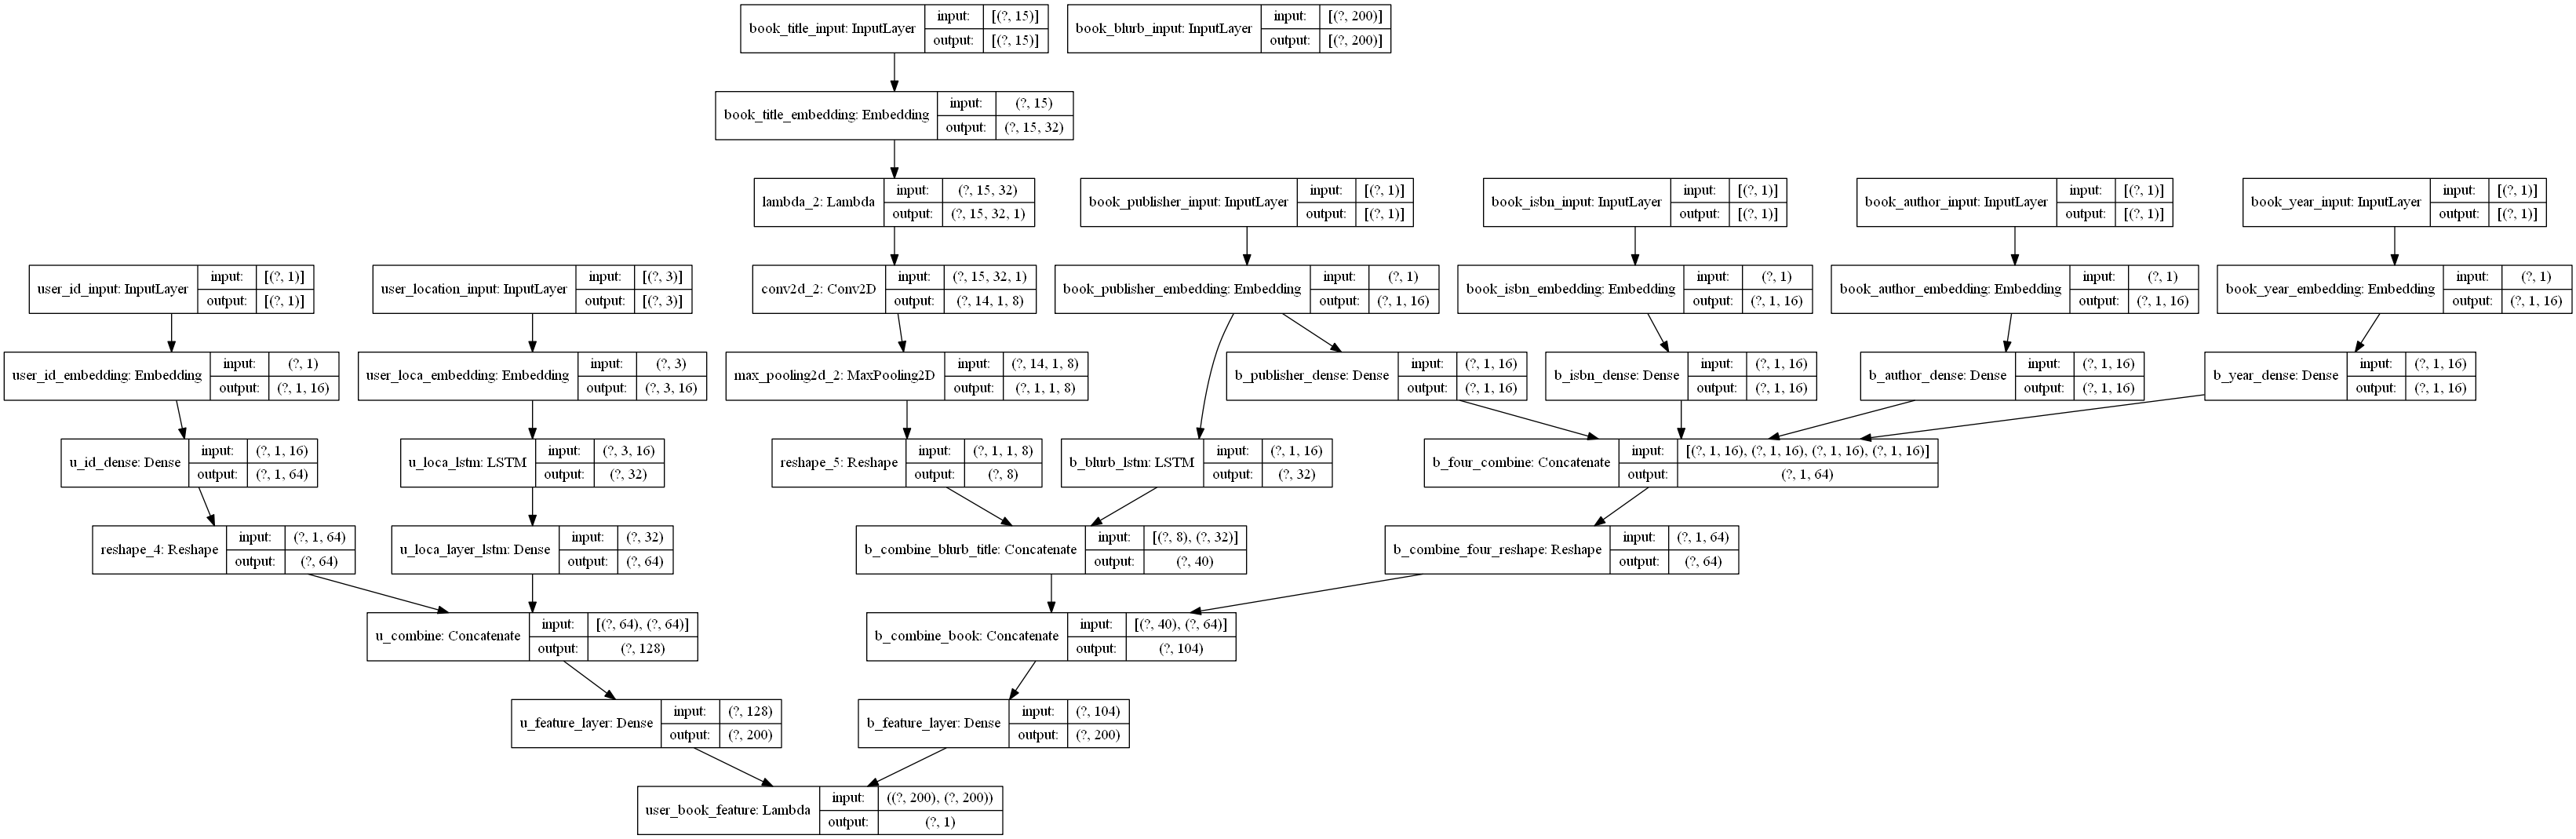

In [26]:
keras.utils.plot_model(model, to_file='model_1.png', show_shapes=True, show_layer_names=True)